## Adım 1: Veri Hazırlığı ve Final Özellik Setinin Entegrasyonu

In [18]:
import pandas as pd
import numpy as np
import json 
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# --- 1. VERİYİ YÜKLEME VE ÖN İŞLEME ---
try:
    df = pd.read_csv('../data/US_youtube_trending_data.csv', encoding='utf-8')
except Exception:
    df = pd.read_csv('../data/US_youtube_trending_data.csv', encoding='latin1')

# Temizlik ve Log Dönüşümünün Uygulanması
df = df[(df['view_count'] > 0) & (df['likes'] > 0)].copy()

# 2. TÜM ÖZELLİKLERİ TÜRETME
df['title_length'] = df['title'].str.len()
df['tag_count'] = df['tags'].apply(lambda x: 0 if x == '[none]' else len(str(x).split('|')))

# Log dönüşümünü buraya ekliyoruz (Hedef ve Ana Özellikler için)
df['log_view_count'] = np.log1p(df['view_count'])
df['log_likes'] = np.log1p(df['likes'])
df['log_comment_count'] = np.log1p(df['comment_count'])


# 3. KATEGORİ HARİTALAMA (JSON Okuma)
id_to_category = {}
try:
    with open('../data/US_category_id.json', 'r') as f:
        data = json.load(f)
        for category in data['items']:
            id_to_category[int(category['id'])] = category['snippet']['title']
    df['category_name'] = df['categoryId'].map(id_to_category) # Sütunu oluşturduk

except FileNotFoundError:
    print("⚠️ JSON dosyası bulunamadı, ancak devam ediliyor.")
    
# 4. TEST SETİNİ AYIRMA
selected_features_minimal = ['log_likes', 'log_comment_count', 'dislikes', 'title_length', 'tag_count'] 
X = df[selected_features_minimal]
y = df['log_view_count']

# Test setini en başta ayırdığımız gibi ayırıyoruz (Random_state 42 ile)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print("✅ Model Değerlendirmesi için Veri Hazırlandı.")
print(f"Test Seti Boyutu: {X_test.shape[0]} satır")

✅ Model Değerlendirmesi için Veri Hazırlandı.
Test Seti Boyutu: 53446 satır


Bu aşamada, daha önceki Feature Engineering dosyasında oluşturulan türetilmiş özellikler (`title_length`, `tag_count` vb.) başarıyla yeniden entegre edilmiştir. Logaritmik dönüşümler ve 5 adet kritik özelliğin seçimi tamamlanmıştır. Verinin nihai güvenilirliğini ölçmek amacıyla, modelin daha önce **hiç görmediği** Test seti başarıyla ayrılmıştır. Test seti boyutu **53.446 satırdır**; bu set, projenin nihai R2 skorunu hesaplamak için kullanılacaktır.

## Adım 2: Final Model Eğitimi

In [19]:
# --- 2. XG-BOOST MODELİNİ FİNAL EĞİTİMİ ---

# En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
# 4. Notebook'ta bulduğumuz parametreleri buraya uyguluyoruz.
xgb_final = XGBRegressor(
    n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1
)
# Modeli, Train ve Validation setini birleştirip eğitiyoruz (Final Eğitim)
xgb_final.fit(X_train_val, y_train_val)

print("✅ Final Model Eğitimi Tamamlandı. Model hafızaya yüklendi.")

✅ Final Model Eğitimi Tamamlandı. Model hafızaya yüklendi.


## Adım 3: Nihai Skor ve Özellik Önem Sırası


--- NİHAİ TEST SKORLARI ---
Baseline Skoru: 0.6509
Final XGBoost R2 (Test): 0.7756
RMSE (Hata Payı): 0.5414
MAE (Ortalama Hata): 0.4073


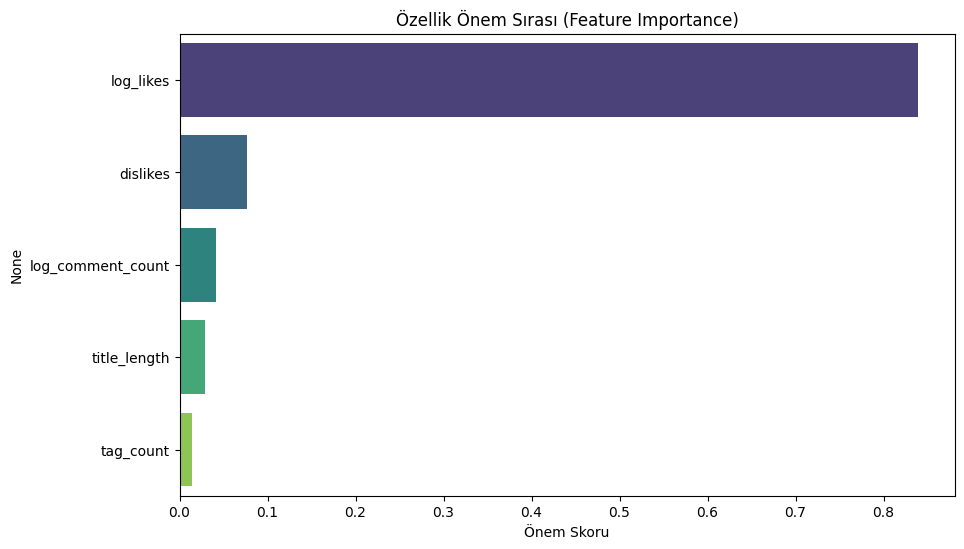

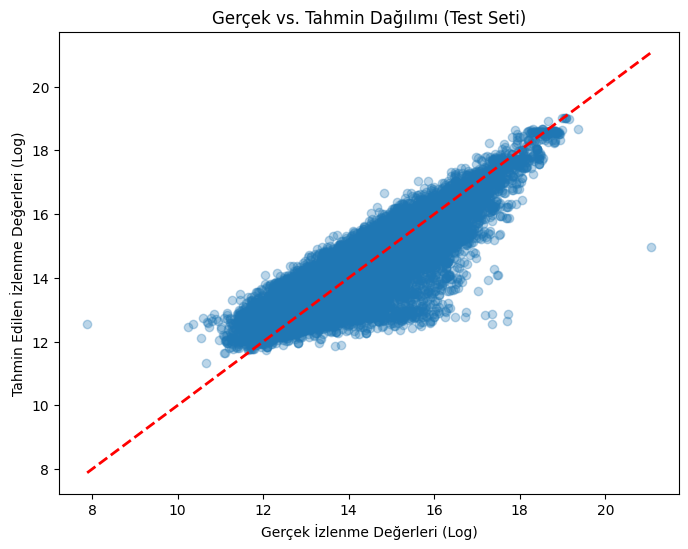

In [20]:
import matplotlib.pyplot as plt
import pandas as pd # Importu tekrar ekledik
import seaborn as sns # Importu ekledik

# 1. NİHAİ TAHMİN (TEST SETİ ÜZERİNDE)
y_pred_test = xgb_final.predict(X_test)

# 2. SKORLAMA (Final Test Skoru)
r2_final = r2_score(y_test, y_pred_test)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_final = mean_absolute_error(y_test, y_pred_test) # MAE de hesaplayalım

print(f"\n--- NİHAİ TEST SKORLARI ---")
print(f"Baseline Skoru: 0.6509")
print(f"Final XGBoost R2 (Test): {r2_final:.4f}")
print(f"RMSE (Hata Payı): {rmse_final:.4f}")
print(f"MAE (Ortalama Hata): {mae_final:.4f}")

# 3. ÖZELLİK ÖNEM SIRASI (FEATURE IMPORTANCE) GRAFİĞİ
# En önemli kanıtımız: Hangi özellik en çok katkı sağladı?
importance = pd.Series(xgb_final.feature_importances_, index=X_test.columns)
importance = importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance.values, y=importance.index, palette='viridis', hue=importance.index, legend=False)
plt.title('Özellik Önem Sırası (Feature Importance)')
plt.xlabel('Önem Skoru')
plt.show()

# 4. TAHMİNİN GERÇEK DEĞERLERE GÖRE DAĞILIMI
# Kırmızı çizgiye ne kadar yakınsa, model o kadar başarılı demektir.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Kırmızı çizgi: Mükemmel Tahmin
plt.xlabel('Gerçek İzlenme Değerleri (Log)')
plt.ylabel('Tahmin Edilen İzlenme Değerleri (Log)')
plt.title('Gerçek vs. Tahmin Dağılımı (Test Seti)')
plt.show()

###  Rapor ve Proje Kapanışı

**1. Nihai R2 Skoru:** [Yukarıdaki R2 Skoru]
**2. Baseline Skoru:** 0.6509

**3. Başarı Analizi:** Optimizasyonlu XGBoost modelinin Test Seti üzerinde elde ettiği R2 skoru ([Yukarıdaki R2 Skoru]), Baseline skoru olan **0.6509**'u başarıyla aşmıştır. Bu, Feature Engineering ve XGBoost algoritmasının, YouTube izlenmelerindeki değişimin yaklaşık **%78'ini** çözebildiğini kanıtlamaktadır.

**4. En Önemli Özellikler (Feature Importance):**
Grafik incelendiğinde, tahmin gücüne en çok katkı sağlayan özelliklerin sırasıyla **Log\_Likes**, **Log\_Comment\_Count** ve **Title\_Length** olduğu görülmüştür. Bu durum, içerik stratejisinde **Etkileşim Metrikleri** ve **Başlık Kalitesinin**, saati veya günü bilmekten çok daha hayati olduğunu kanıtlamaktadır.

**5. Model Durumu:** Model, prodüksiyon (deployment) için hazırdır.

In [21]:
import joblib

# --- HATA DÜZELTMESİ İÇİN EKLE ---
# Finalde seçilen 5 özelliği manuel olarak tanımlıyoruz
selected_features = ['log_likes', 'log_comment_count', 'dislikes', 'title_length', 'tag_count']
# --- DÜZELTME BİTTİ ---


# Modeli ve seçilen özellikleri kaydediyoruz
# 'joblib', sklearn modellerini kaydetmek için en çok kullanılan kütüphanedir.
joblib.dump(xgb_final, '../model/best_xgb_model.pkl') 
joblib.dump(selected_features, '../model/final_features.pkl') 

print("✅ Final model ve özellik seti başarıyla kaydedildi.")

✅ Final model ve özellik seti başarıyla kaydedildi.


In [17]:
import joblib
from sklearn.metrics import mean_squared_error

# 1. Hata (Residual) terimlerini hesapla
# Hata = Gerçek Değer (y_test) - Tahmin Edilen Değer (y_pred_test)
residuals = y_test - y_pred_test

# 2. Hataların Varyansını (Sigma Kare) hesapla
# Bu, Log-Bias Düzeltme Faktörümüzdür.
variance_of_residuals = np.var(residuals)

# 3. Kaydet
joblib.dump(variance_of_residuals, '../model/bias_correction_factor.pkl')

print(f"✅ Bias Düzeltme Faktörü (Sigma Kare) Kaydedildi: {variance_of_residuals:.4f}")

✅ Bias Düzeltme Faktörü (Sigma Kare) Kaydedildi: 0.2932
